# Libraries

In [29]:
import pickle
import nltk 
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

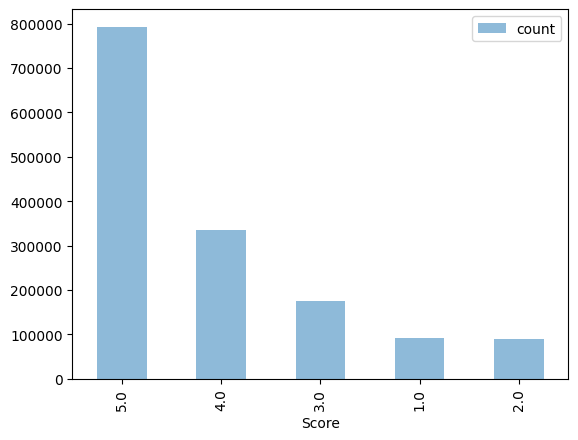


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [14]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [15]:
def add_features_to(df):
    # This is where you can do all your feature extraction
    

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    # Process 'Time' feature
    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    df['ReviewYear'] = df['Time'].dt.year
    df['ReviewMonth'] = df['Time'].dt.month
    
    # Combine text features
    df['CombinedText'] = df['Summary'].fillna('') + ' ' + df['Text'].fillna('')

    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]
    

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [16]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [17]:

numerical_features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'ReviewYear', 'ReviewMonth']

nltk.download('stopwords')
stop_words = stopwords.words('english')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2) ,stop_words=stop_words), 'CombinedText')
    ])

# Create a pipeline with XGBoost
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='multi:softmax',
        num_class=5,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        eval_metric='mlogloss',
        n_jobs =-1
    ))
])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lanyikun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Model Creation

In [25]:
import time
import numpy as np

""" # Start timing
start_time = time.time()

# Train on a subset
X_train_subset = X_train[:10000]
Y_train_subset = Y_train[:10000]

Y_train_subset_adjusted = Y_train_subset - 1
Y_train_subset_adjusted = Y_train_subset_adjusted.astype(int)


print("Shape of X_train_subset:", X_train_subset.shape)
print("Shape of Y_train_subset_adjusted:", Y_train_subset_adjusted.shape)



pipeline.fit(X_train_subset, Y_train_subset_adjusted)





# End timing
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time on subset: {elapsed_time / 60:.2f} minutes") """


# Learn the model
# Adjust labels to start from 0
Y_train_adjusted = (Y_train - 1).astype(int)
Y_test_adjusted = (Y_test - 1).astype(int)

# Verify labels
print("Unique labels in Y_train_adjusted:", np.unique(Y_train_adjusted))
print("Unique labels in Y_test_adjusted:", np.unique(Y_test_adjusted))

pipeline.fit(X_train, Y_train_adjusted)

# Predict the score using the model
Y_pred_adjusted = pipeline.predict(X_test)

# Map predictions back to original labels
Y_pred = Y_pred_adjusted + 1
Y_test_original = Y_test_adjusted + 1

print(classification_report(Y_test_original, Y_pred))

Unique labels in Y_train_adjusted: [0 1 2 3 4]
Unique labels in Y_test_adjusted: [0 1 2 3 4]


/Users/lanyikun/Desktop/Year 3/CS506/assingments/midterm/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [05:33:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           1       0.62      0.58      0.60     22906
           2       0.49      0.14      0.22     22406
           3       0.53      0.19      0.28     44171
           4       0.47      0.23      0.31     83810
           5       0.65      0.94      0.77    198043

    accuracy                           0.62    371336
   macro avg       0.55      0.42      0.44    371336
weighted avg       0.59      0.62      0.57    371336



# Model Evaluation

Accuracy on testing set =  0.6233276601245233


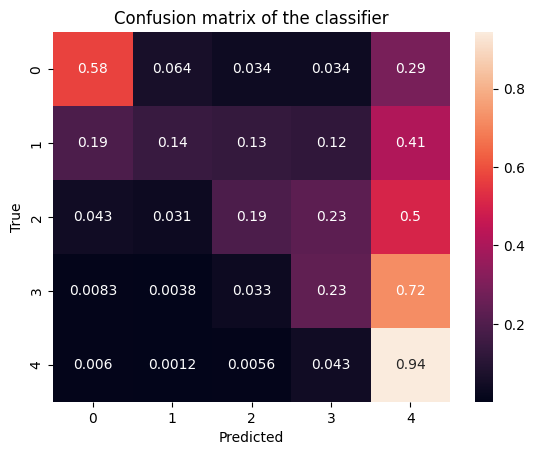

In [26]:
# Evaluate your model on the testing set

print("Accuracy on testing set = ", accuracy_score(Y_test_original, Y_pred))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [28]:
# Create the submission file
X_submission['Score'] = pipeline.predict(X_submission)
X_submission['Score'] = X_submission['Score'] + 1
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)